In this notebook we launch the following pipeline
- comparison of variences between 75_regions dataset and OneBatch dataset
- estimation of the parameters of lipids distributions in OneBatch
- generation of fake brains from the estimated distributions
- applying Random Forest ML algorithm to the generated data
- identifying the most important features

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from copy import copy

import warnings
warnings.filterwarnings('ignore')

# Helpful functions

In [38]:
def get_only_four(lipids):
    """Obtain the regions for which exactly four observations for distinct brains are available.
    """
    brains_per_region = lipids.groupby("Region_detailed")["Brain_abbr"].apply(lambda x: str(sorted(list(x))))
    brains_set = str(sorted(list(set(lipids.Brain_abbr.unique()))))
    only_four = set(brains_per_region[brains_per_region == brains_set].index)
    return only_four


def normalize(dataset):
    """Subtract mean over regions for every lipid in each brain.
    """
    new_dataset = []
    for brain in sorted(dataset.Brain_abbr.unique()):
        existing_values = dataset[dataset["Brain_abbr"] == brain].iloc[:, 2:]
        mean_per_brain = existing_values.mean()
        new_dataset.append(existing_values.values - mean_per_brain.values)

    new_dataset = pd.DataFrame(np.concatenate(new_dataset))
    new_dataset.insert(loc=0, column="Brain_abbr", value=dataset.Brain_abbr.values)
    new_dataset.insert(loc=1, column="Region_detailed", value=dataset.Region_detailed.values)
    new_dataset.columns = dataset.columns
    return new_dataset


def prepare_for_dim_reduction(dataset):
    """Reshape the dataset in such a way that all observation for each brain become a single vector.
    """
    new_dataset = []
    for brain in sorted(dataset.Brain_abbr.unique()):
        existing_values = dataset[dataset["Brain_abbr"] == brain].iloc[:, 2:].values.reshape(1, -1)
        new_dataset.append(existing_values)
    new_dataset = np.concatenate(new_dataset)
    return new_dataset


def make_dataset_ready_for_training(fake_dataset):
    half_len = len(fake_dataset) // 2
    hc_fake = np.hstack(fake_dataset[:half_len])
    sz_fake = np.hstack(fake_dataset[half_len:])
    return np.vstack([hc_fake, sz_fake])

# read the data

In [39]:
onebatch = pd.read_csv("../data/OneBatch3_FINAL2.csv").sort_values(by=["Donor", "Region"])

h_lipids = pd.read_csv("../data/ours_maria_version/rtmz_H_pos_std_weight_norm_TL_COMBINED.csv", index_col=0)
sz_lipids = pd.read_csv("../data/ours_maria_version/rtmz_SZ_pos_std_weight_norm_TL_COMBINED.csv", index_col=0)

h_lipids.index = h_lipids.index.str.split(".").str[0]

meta = pd.read_csv("../data/ours_maria_version/meta_pos_COMBINED.csv")
meta = meta[["Sample", "Brain_abbr", "Region_detailed"]].set_index("Sample")

sz_lipids = meta.join(sz_lipids, how="inner")
# sz_lipids["region_id"] = sz_lipids.Region_detailed.str.split(" ").str[0].astype(int)

h_lipids = meta.join(h_lipids, how="inner")
# h_lipids["region_id"] = h_lipids.Region_detailed.str.split(" ").str[0].astype(int)

meta_lipids = pd.read_csv("../data/ours_maria_version/TL_combined.csv")
lipid_species_colon_replaced = meta_lipids["Lipid.species"].str.replace(":", " ", regex=False).tolist()
lipids_columns = ["Brain_abbr", "Region_detailed"] + lipid_species_colon_replaced
h_lipids.columns = lipids_columns
sz_lipids.columns = lipids_columns

h_lipids = h_lipids.sort_values(by=["Brain_abbr", "Region_detailed"])
sz_lipids = sz_lipids.sort_values(by=["Brain_abbr", "Region_detailed"])

## Investigate

In [40]:
regions_75_lipids = meta_lipids["Lipid.species"].str.replace(":", " ").unique().tolist()
onetabch_lipids = onebatch.columns[9:].str.replace(".", " ", regex=False).tolist()
common_lipids = list(set(regions_75_lipids) & set(onetabch_lipids))
print("Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids:")
print(len(regions_75_lipids), len(onetabch_lipids), len(common_lipids))
duplicates = h_lipids.columns.value_counts()[h_lipids.columns.value_counts() != 1].index
print("\nCommon lipids after removing duplicates:")
common_lipids = list(set(common_lipids) - set(duplicates))
print(len(common_lipids))

h_only_four = get_only_four(h_lipids)
sz_only_four = get_only_four(sz_lipids)
regions_only_four = list(h_only_four & sz_only_four)
print("\nNum of regions for which there are 4 SZ and 4 HC observations")
print(len(regions_only_four))

Lipids in 75 regions dataset, lipids in onebathc dataset, common lipids:
347 445 58

Common lipids after removing duplicates:
53

Num of regions for which there are 4 SZ and 4 HC observations
50


In [41]:
onebatch.columns = onebatch.columns.str.replace(".", " ", regex=False)
onebatch_only_common = copy(onebatch[onebatch.columns[:9].tolist() + common_lipids])

onebatch_only_common.iloc[:, 9:] *= np.log10(2)
onebatch_only_common.head()

,Unnamed: 0,Sample,SZ,Type,Region,Donor,Order,Mass,MassCoef,PC 39 6,...,FA 22 6,LPC 20 1,FA 22 5,LPE 22 4,LPE 18 1,CAR 18 0,FA 18 1,CAR 18 1,LPC 20 3,LPE 20 1
3,V22,HC10M_f_36_CCp_x2_NEG_068,HC,Sample,BA22,HC10M,68,18.6,-0.048999,6.373688,...,8.308915,4.713592,6.874205,6.640364,6.356271,4.054888,7.272514,4.840710,5.411370,4.789178
1,V20,HC10M_f_36_BA9_x2_NEG_041,HC,Sample,BA9,HC10M,41,16.4,-0.230605,6.177917,...,8.008658,4.337230,6.641840,6.522458,6.245446,4.765968,7.049261,4.513183,5.323759,4.724955
0,V19,HC10M_f_36_BA22p_x2_NEG_093,HC,Sample,CCp,HC10M,93,24.9,0.371845,5.914134,...,7.671178,4.659420,6.910140,6.367051,6.345937,4.881487,7.484024,5.522580,4.924550,5.449968
2,V21,HC10M_f_36_CCa_x2_NEG_092,HC,Sample,Cca,HC10M,92,21.1,0.132942,5.833264,...,7.856570,4.464110,6.869445,6.435581,6.403936,4.081022,7.630714,5.255190,4.763908,5.383691
4,V23,HC16M_f_54_BA22p_x2_NEG_006,HC,Sample,BA22,HC16M,6,14.6,-0.398333,6.206032,...,7.851324,4.654245,6.952724,6.660952,6.362037,4.550680,7.127255,4.729510,4.792293,5.220641


OneBatch is log2 data. 75_regions is log10 data. Therefore, we multiply Onebatch by $\log_{10}(2)$, because $\log_{10}(x) = \log_{10}(2) \times \log_2(x)$

## Normalize both dataset (make mean value for each lipid in each brain zero)

In [42]:
dataset = onebatch
new_dataset = []
for brain in dataset.Donor.unique():
    existing_values = dataset[dataset["Donor"] == brain].iloc[:, 9:]
    mean_per_brain = existing_values.mean()
    new_dataset.append((existing_values.values - mean_per_brain.values))

new_dataset = pd.DataFrame(np.concatenate(new_dataset))

new_dataset = pd.concat([onebatch.iloc[:, :9], new_dataset], axis=1)
new_dataset.columns = onebatch.columns
onebatch = new_dataset

for brain in onebatch.Donor.unique():
    print(onebatch[onebatch.Donor == brain].iloc[:, 9:].mean().mean())   

sz_lipids = sz_lipids[sz_lipids.Region_detailed.isin(regions_only_four)]
sz_lipids = normalize(sz_lipids)
for brain in sz_lipids.Brain_abbr.unique():
    print(sz_lipids[sz_lipids.Brain_abbr == brain].mean().mean())    
    
h_lipids = h_lipids[h_lipids.Region_detailed.isin(regions_only_four)]
h_lipids = normalize(h_lipids)
for brain in h_lipids.Brain_abbr.unique():
    print(h_lipids[h_lipids.Brain_abbr == brain].mean().mean())

-1.94600889709578e-17
-1.3721857607726653e-16
-2.8441668496015244e-17
-9.181170181169833e-17
-1.995906561123877e-18
6.4866963236526e-18
1.94600889709578e-17
7.384854276158345e-17
3.1934504977982034e-17
-6.536593987680696e-17
8.233114564635993e-17
-4.490789762528723e-17
-7.484649604214538e-18
-3.393041153910591e-17
1.1975439366743262e-17
-1.29733926473052e-17
4.989766402809692e-17
-1.5667866504822433e-16
-5.937822019343534e-17
-1.896111233067683e-17
-7.983626244495508e-18
-2.1455995532081678e-17
-7.78403558838312e-17
9.430658501310319e-17
6.278417393132943e-19
-1.6801643629592778e-18
1.2468038914408504e-18
1.3822862526253883e-20
-2.866458902546795e-18
-7.845161049668193e-20
-6.925162583516909e-20
1.9924374741690868e-18


In [43]:
all_observations_combined_75 = np.concatenate([h_lipids.iloc[:, 2:].values, sz_lipids.iloc[:, 2:].values]).reshape(-1,)

In [44]:
all_observations_combined_75.shape

(151600,)

In [45]:
all_observations_combined_75.mean(), all_observations_combined_75.var()

(-8.99895813099863e-18, 1.0203092694492342)

In [46]:
from scipy.stats import norm

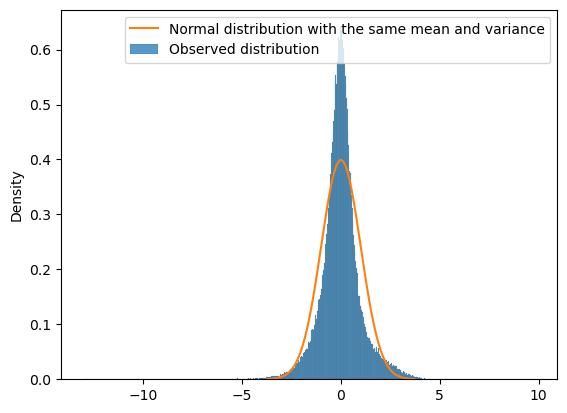

In [47]:
x = np.linspace(
    norm.ppf(0.0001, loc=all_observations_combined_75.mean(), scale=all_observations_combined_75.std()),
    norm.ppf(0.9999, loc=all_observations_combined_75.mean(), scale=all_observations_combined_75.std()),
                1000)
plt.plot(x, norm.pdf(x), c="C1", label="Normal distribution with the same mean and variance")
sns.histplot(all_observations_combined_75, stat="density", label="Observed distribution")
plt.legend()
plt.show()

## Data visualization

### 75_regions (normalized), brain as object

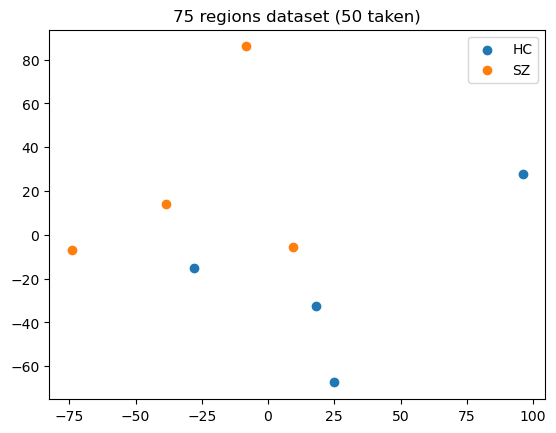

In [48]:
h_lipids_dim_reduction = prepare_for_dim_reduction(h_lipids[h_lipids.Region_detailed.isin(regions_only_four)])
sz_lipids_dim_reduction = prepare_for_dim_reduction(sz_lipids[sz_lipids.Region_detailed.isin(regions_only_four)])

dim_reduction = PCA(n_components=2)

lipids_dim_reduction = dim_reduction.fit_transform(np.concatenate([h_lipids_dim_reduction, sz_lipids_dim_reduction]))

plt.scatter(lipids_dim_reduction[:4, 0], lipids_dim_reduction[:4, 1], label="HC")
plt.scatter(lipids_dim_reduction[4:, 0], lipids_dim_reduction[4:, 1], label="SZ")
# plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
# plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
plt.title(f"75 regions dataset (50 taken)")
plt.legend()
plt.show()

### One batch (normalized), brain as object

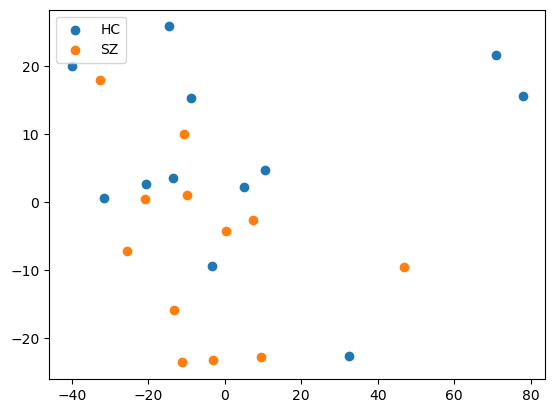

In [49]:
new_onebatch = []
for brain in onebatch.Donor.unique():
    existing_values = onebatch[onebatch["Donor"] == brain].iloc[:, 9:].values.reshape(1, -1)
    new_onebatch.append(existing_values)
new_onebatch = np.concatenate(new_onebatch)

dim_reduction = PCA(n_components=2)

dim_reduction_fitted = dim_reduction.fit_transform(new_onebatch)

plt.scatter(dim_reduction_fitted[:12, 0], dim_reduction_fitted[:12, 1], label="HC")
plt.scatter(dim_reduction_fitted[12:, 0], dim_reduction_fitted[12:, 1], label="SZ")
plt.legend()
plt.show()

## Example lipid profile

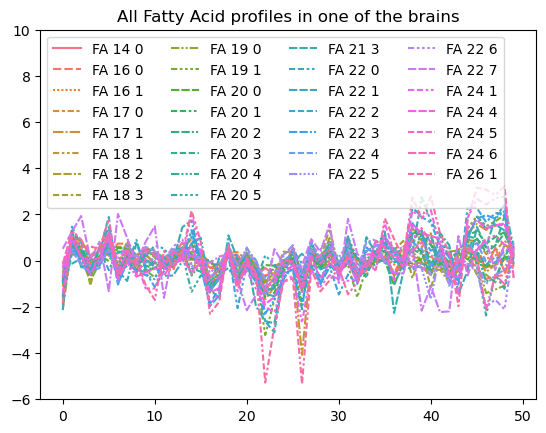

In [36]:
sns.lineplot(h_lipids[h_lipids["Brain_abbr"] == "HA"].loc[:, h_lipids.columns.str.contains("FA")])
plt.ylim(-6, 10)
plt.title("All Fatty Acid profiles in one of the brains")
plt.legend(ncols=4)
plt.savefig("../data/pics/example_profiles.pdf")

- BA9: 35 Dorsolateral Prefrontal Medial (BA9m), 34 Dorsolateral Prefrontal (BA9)
- BA22: 26 2ary Auditory, language (BA22a), 28 2ary Auditory, Wernicke (BA22p)

In [53]:
# region_translate = {
#     "CCp": '74 Corpus Callosum Posterior',
#     "BA9": "34 Dorsolateral Prefrontal (BA9)",
#     "Cca": '73 Corpus Callosum Anterior',
#     "BA22": "28 2ary Auditory, Wernicke (BA22p)",
# }

region_translate = {
    '74 Corpus Callosum Posterior': "CCp",
    "34 Dorsolateral Prefrontal (BA9)": "BA9",
    '73 Corpus Callosum Anterior': "Cca",
    "28 2ary Auditory, Wernicke (BA22p)": "BA22",
}

# Generate fake dataset

## Prepare the labels

In [54]:
N_SAMPLES = 1000

brains_labels_hc = [f"HC{i + 1}" for i in range(N_SAMPLES)] * len(regions_only_four)
brains_labels_sz = [f"SZ{i + 1}" for i in range(N_SAMPLES)] * len(regions_only_four)
brains_labels = np.array(brains_labels_hc + brains_labels_sz)

regions_labels = np.concatenate([np.array([region] * N_SAMPLES) for region in regions_only_four])
regions_labels = np.concatenate([regions_labels, regions_labels])

## Sampling

In [55]:
fake_dataset = []
fake_dataset_75 = []
std_comparison = []

hc_column = []
region_nm_column = []

for human_type in ["HC", "SZ"]:
    for region_nm in regions_only_four:
        
        # First, we generate the data based on 75_regions (taking 50 of them)
        # In this loop we generate N_SAMPLES individuals for each region_nm
        if human_type == "HC":
            regions_75_lipids = h_lipids[h_lipids["Region_detailed"] == region_nm][common_lipids]
        else:
            regions_75_lipids = sz_lipids[sz_lipids["Region_detailed"] == region_nm][common_lipids]

        generated_75 = np.random.normal(
            loc=regions_75_lipids.mean(), scale=regions_75_lipids.std(), size=(N_SAMPLES, len(common_lipids))
        )
        fake_dataset_75.append(generated_75)
        
        # Second, we generate the data based on OneBatch
        if region_nm in region_translate:
            to_plot = onebatch_only_common[
                (onebatch_only_common.SZ == human_type) 
                & (onebatch_only_common.Region == region_translate[region_nm])
            ]
            onebatch_lipids = to_plot[common_lipids]
            
            # We save the mean fold-difference between variances
            std_comparison.append(
                [human_type, region_nm, (regions_75_lipids.var() / onebatch_lipids.var()).mean()]
            )
        
            generated = np.random.normal(
                loc=onebatch_lipids.mean(), scale=onebatch_lipids.std(), size=(N_SAMPLES, len(common_lipids))
            )
            fake_dataset.append(generated)

In [56]:
print("Standard deviation comparison, 75 divide by onebatch")
pd.DataFrame(np.array(std_comparison), columns=["SZ", "region", "mean fold-change"])

Standard deviation comparison, 75 divide by onebatch


,SZ,region,mean fold-change
0,HC,74 Corpus Callosum Posterior,32.29861275730276
1,HC,34 Dorsolateral Prefrontal (BA9),8.684883791897407
2,HC,73 Corpus Callosum Anterior,6.3808274513967245
3,HC,"28 2ary Auditory, Wernicke (BA22p)",8.517620028679719
4,SZ,74 Corpus Callosum Posterior,5.869699031127151
5,SZ,34 Dorsolateral Prefrontal (BA9),14.497389968506189
6,SZ,73 Corpus Callosum Anterior,7.59923602059043
7,SZ,"28 2ary Auditory, Wernicke (BA22p)",3.6845689673971105


## Normalize

In [57]:
fake_dataset_75 = pd.DataFrame(np.concatenate(fake_dataset_75))
fake_dataset_75.insert(0, "Brain_abbr", brains_labels)
fake_dataset_75.insert(1, "Region_detailed", regions_labels)

fake_dataset_75 = fake_dataset_75.sort_values(by=["Brain_abbr", "Region_detailed"])

fake_dataset_75 = normalize(fake_dataset_75)


for brain in fake_dataset_75.Brain_abbr.unique():
    if abs(fake_dataset_75[fake_dataset_75.Brain_abbr == brain].mean().mean()) > 1e-10:
        print("Not normalized", brain)

In [59]:
train_dataset = make_dataset_ready_for_training(fake_dataset_75)

In [60]:
fake_dataset_75.head()

,Brain_abbr,Region_detailed,0,1,2,3,4,5,6,7,...,43,44,45,46,47,48,49,50,51,52
0,HC1,1 Cerebellar Grey Matter,-0.319722,-0.085736,-0.452909,0.655342,-1.223956,-1.254063,-1.836024,0.824756,...,0.675163,0.009068,-1.109452,-0.581886,0.266526,0.393476,0.150411,0.459382,0.452459,-0.540585
1,HC1,10 2ary/3ary Visual Posterior (BA18/19p),0.442487,0.013178,0.500196,0.628788,0.072318,-0.169949,-0.336001,-0.513591,...,0.827719,-0.605008,0.235654,-0.051777,0.855833,-0.252589,0.469177,0.407882,0.090028,0.652624
2,HC1,14 1ary Visual Posterior (BA17p),1.209253,-0.096248,-0.907473,0.834605,-0.217186,-0.928265,-0.539131,-0.414263,...,-0.663094,-1.518533,0.390812,-0.210103,0.289789,-0.166270,0.030059,-0.290525,0.130699,0.476808
3,HC1,15 1ary Motor (BA4),0.540734,-0.477906,1.115099,1.303845,0.072626,0.296019,2.196993,0.327832,...,0.460538,-0.453885,0.536527,1.409558,-0.069169,0.644790,0.332639,0.887605,-0.011526,2.225978
4,HC1,16 1ary Auditory (BA41/42),0.190939,0.042839,1.069270,-0.744201,0.211558,0.424822,0.472213,-0.677163,...,0.149626,-0.604693,0.036535,-0.052767,-0.347489,-0.222317,0.181921,0.390430,-0.260381,0.808977


In [61]:
fake_dataset_75_reduction = prepare_for_dim_reduction(fake_dataset_75)

In [62]:
fake_dataset_75_reduction.shape

(2000, 2650)

In [63]:
fake_dataset_75

,Brain_abbr,Region_detailed,0,1,2,3,4,5,6,7,...,43,44,45,46,47,48,49,50,51,52
0,HC1,1 Cerebellar Grey Matter,-0.319722,-0.085736,-0.452909,0.655342,-1.223956,-1.254063,-1.836024,0.824756,...,0.675163,0.009068,-1.109452,-0.581886,0.266526,0.393476,0.150411,0.459382,0.452459,-0.540585
1,HC1,10 2ary/3ary Visual Posterior (BA18/19p),0.442487,0.013178,0.500196,0.628788,0.072318,-0.169949,-0.336001,-0.513591,...,0.827719,-0.605008,0.235654,-0.051777,0.855833,-0.252589,0.469177,0.407882,0.090028,0.652624
2,HC1,14 1ary Visual Posterior (BA17p),1.209253,-0.096248,-0.907473,0.834605,-0.217186,-0.928265,-0.539131,-0.414263,...,-0.663094,-1.518533,0.390812,-0.210103,0.289789,-0.166270,0.030059,-0.290525,0.130699,0.476808
3,HC1,15 1ary Motor (BA4),0.540734,-0.477906,1.115099,1.303845,0.072626,0.296019,2.196993,0.327832,...,0.460538,-0.453885,0.536527,1.409558,-0.069169,0.644790,0.332639,0.887605,-0.011526,2.225978
4,HC1,16 1ary Auditory (BA41/42),0.190939,0.042839,1.069270,-0.744201,0.211558,0.424822,0.472213,-0.677163,...,0.149626,-0.604693,0.036535,-0.052767,-0.347489,-0.222317,0.181921,0.390430,-0.260381,0.808977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,SZ999,72 Internal Capsule,0.360151,0.619490,2.509189,-1.541223,1.891761,1.277156,1.657267,1.972437,...,-1.054641,0.744128,0.296883,0.632920,0.539805,1.009595,0.497132,1.842653,0.477374,2.264943
99996,SZ999,73 Corpus Callosum Anterior,-1.444615,0.130434,1.952209,-2.867773,0.868189,0.838115,2.411012,2.617004,...,-1.587807,0.749875,-0.626737,0.979232,1.515642,0.483178,1.512860,1.628842,-1.247613,1.845278
99997,SZ999,74 Corpus Callosum Posterior,-0.991505,0.588184,2.209006,-1.097439,1.868513,0.885821,2.398795,1.844407,...,-2.759987,0.851592,-0.821129,0.492040,0.378692,0.441564,0.470139,4.720116,-1.803716,1.477948
99998,SZ999,75 Cerebellar White Matter,-0.294114,0.278092,0.255016,-0.610134,1.420825,0.793488,1.881735,0.371135,...,-1.269688,0.739058,-1.290585,0.798686,1.657071,0.784485,0.017434,1.768996,-0.438648,3.128219


## Plot fake dataset (normalized), 

### brain as object (old approach)

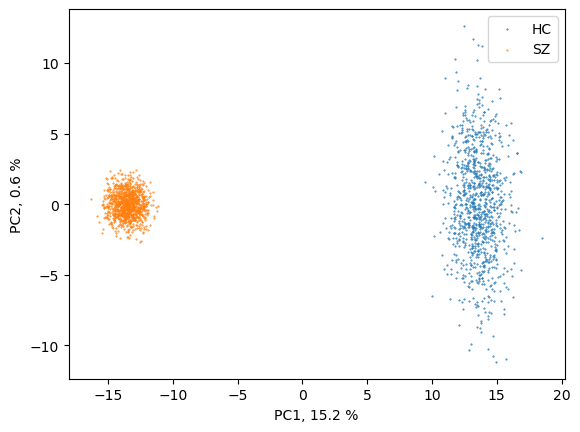

In [65]:
dim_reduction = PCA(n_components=2)
fake_dataset_dim_reduction = dim_reduction.fit_transform(fake_dataset_75_reduction)
plt.scatter(fake_dataset_dim_reduction[:N_SAMPLES, 0], fake_dataset_dim_reduction[:N_SAMPLES, 1], s=.2, label="HC")
plt.scatter(fake_dataset_dim_reduction[N_SAMPLES:, 0], fake_dataset_dim_reduction[N_SAMPLES:, 1], s=.2, label="SZ")
plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
# plt.title(f"n={N_SAMPLES} for each class")
plt.legend()
plt.savefig("../data/pics/brain_as_object_lipids.png", dpi=200)

### region as object (up-to-date approach)

In [29]:
fake_dataset_75.shape

(100000, 55)

In [30]:
use_PCA = True
if use_PCA:
    dim_reduction = PCA(n_components=2)
else:
    dim_reduction = MDS(n_components=2)
    
fake_dataset_dim_reduction = dim_reduction.fit_transform(fake_dataset_75.iloc[:, 2:])

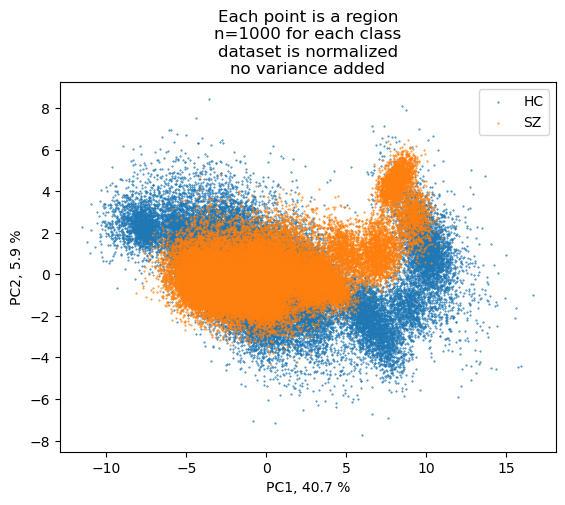

In [31]:
plt.scatter(fake_dataset_dim_reduction[:N_SAMPLES * 50, 0], fake_dataset_dim_reduction[:N_SAMPLES * 50, 1], s=.2, label="HC")
plt.scatter(fake_dataset_dim_reduction[N_SAMPLES * 50:, 0], fake_dataset_dim_reduction[N_SAMPLES * 50:, 1], s=.2, label="SZ")
if use_PCA:
    plt.xlabel(f"PC1, {dim_reduction.explained_variance_ratio_[0] * 100 :.1f} %")
    plt.ylabel(f"PC2, {dim_reduction.explained_variance_ratio_[1] * 100 :.1f} %")
plt.title(f"Each point is a region\nn={N_SAMPLES} for each class\ndataset is normalized\nno variance added")
plt.legend()
plt.savefig("../data/pics/region_as_object_75_gen.pdf", bbox_inches='tight')

## Plot lipids

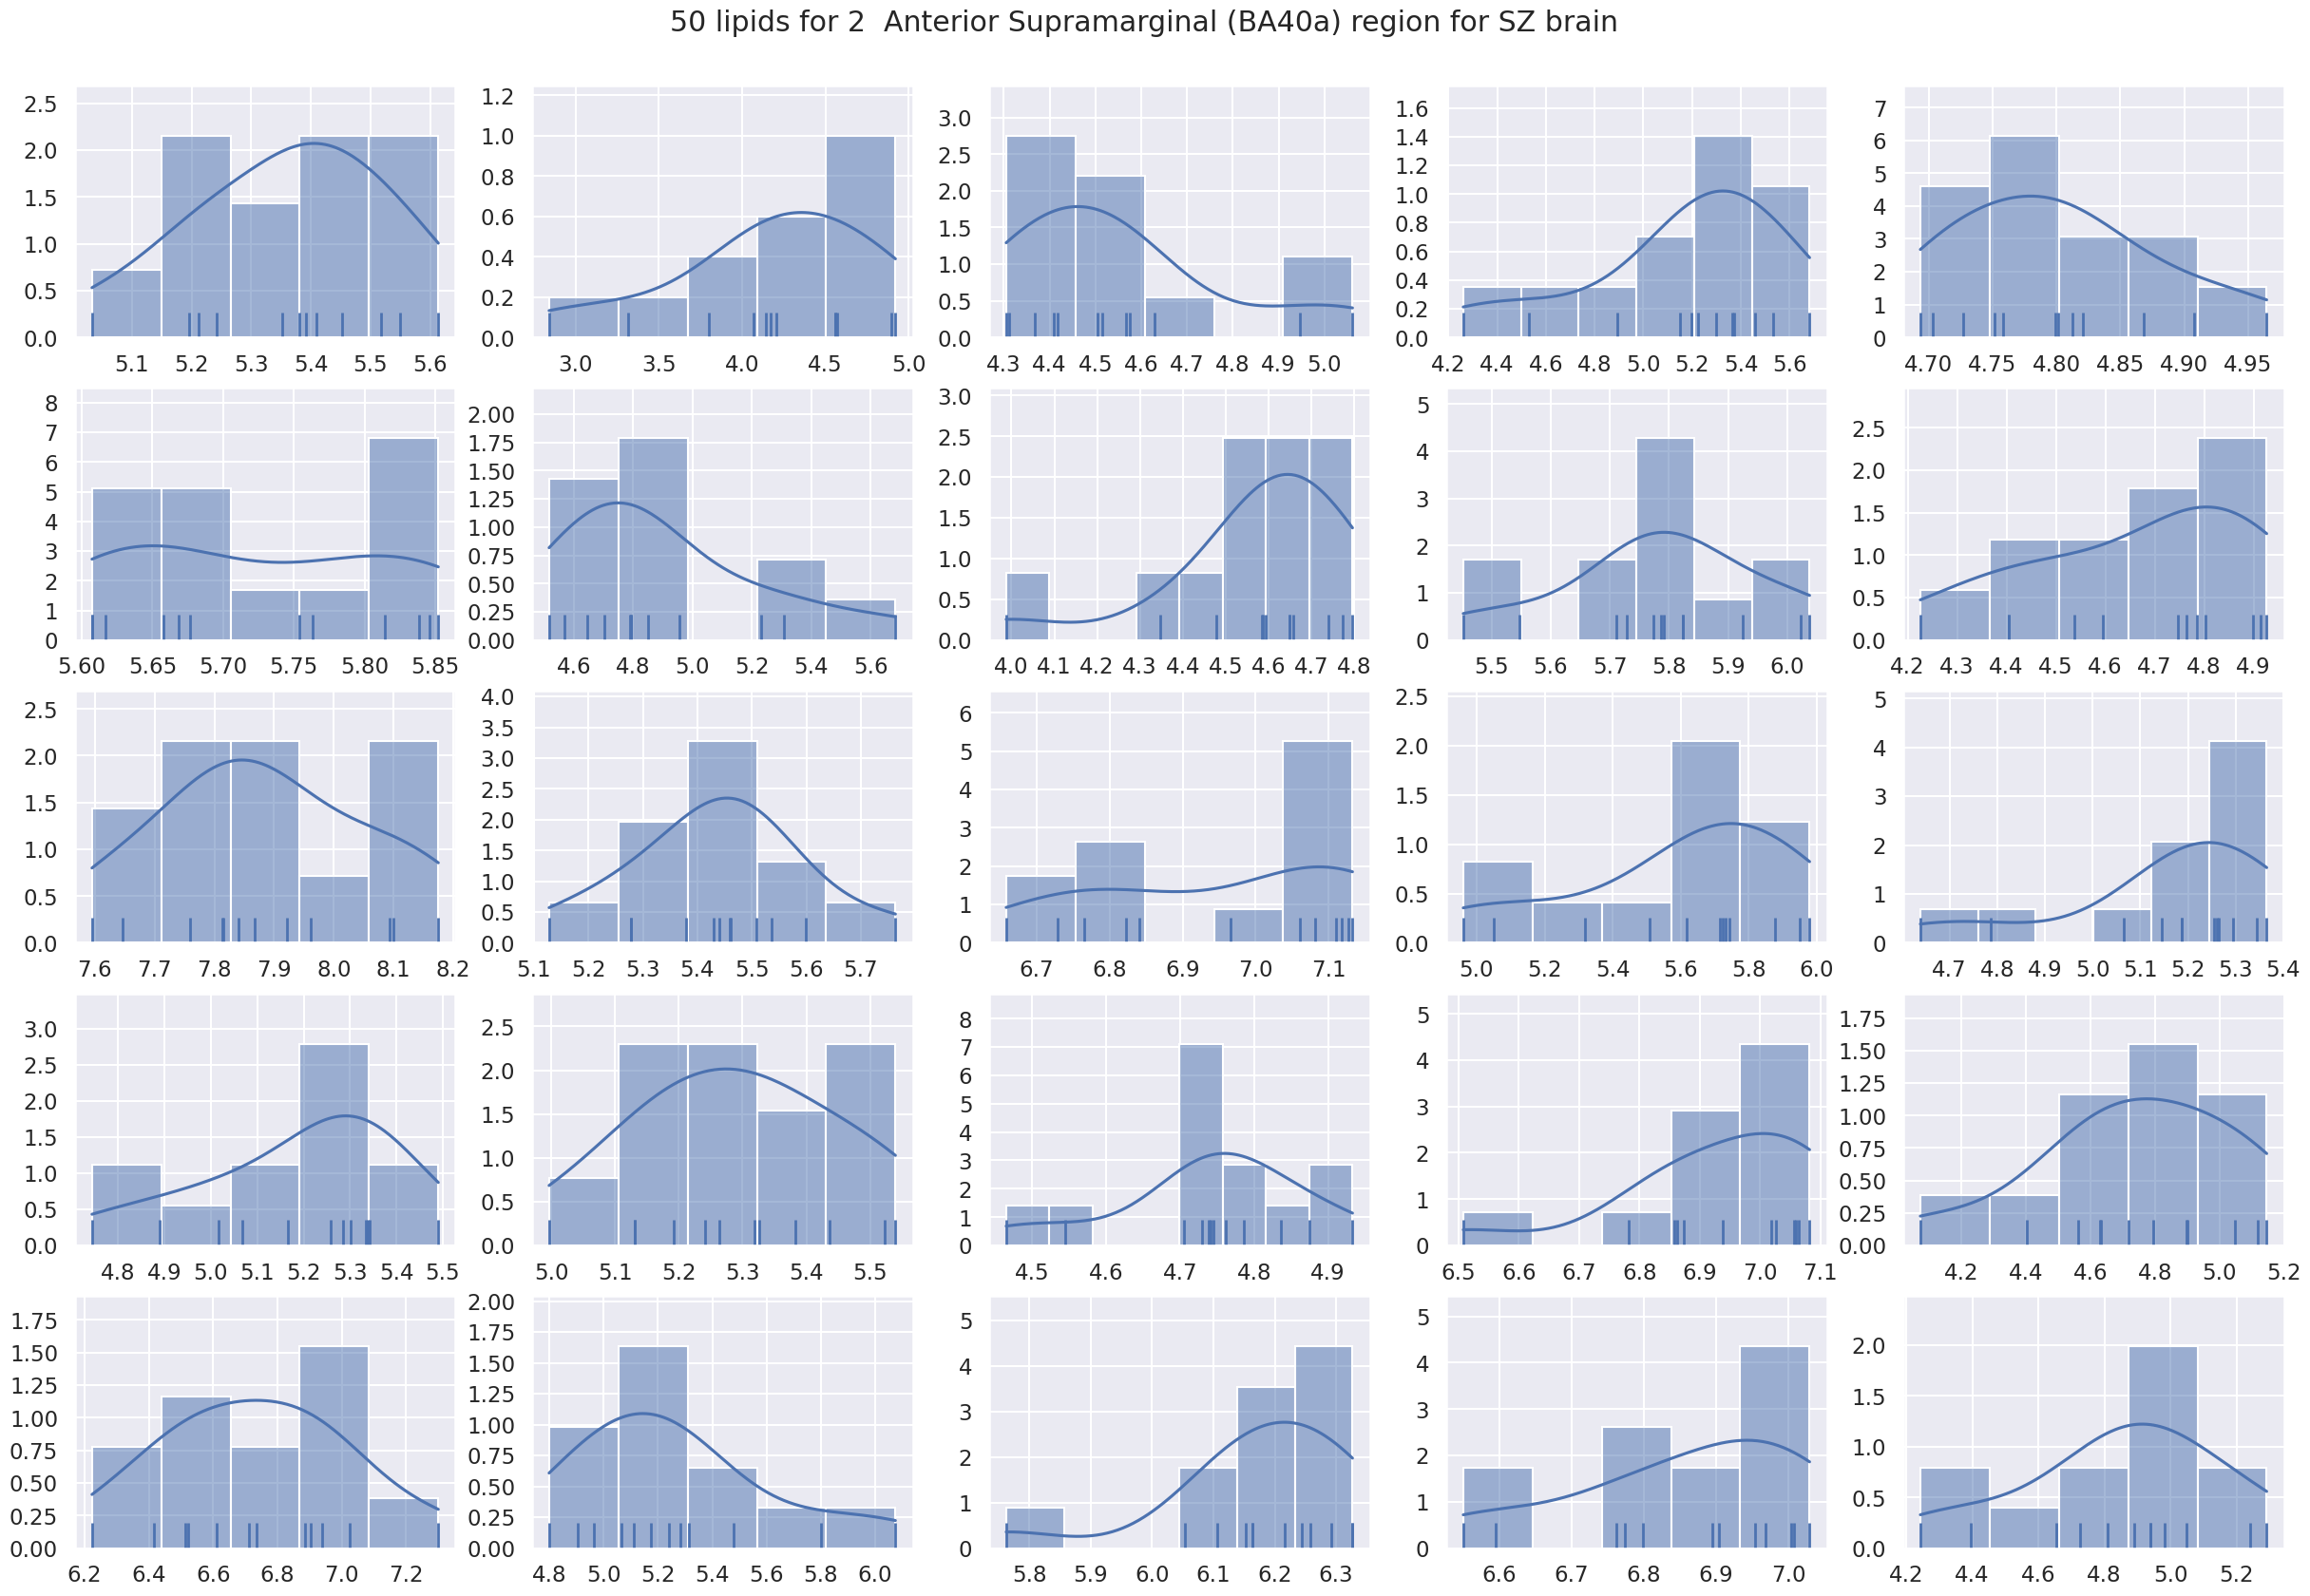

In [32]:
sns.set_theme()
sns.set_context("talk")

fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(5*6, 5*4))
axs = axs.flatten()
for i in range(25):
    sns.histplot(to_plot.iloc[:, i + 9], kde=True, stat="density", ax=axs[i])
    sns.rugplot(to_plot.iloc[:, i + 9], ax=axs[i], height=0.1, linewidth=2)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    
plt.suptitle(f"50 lipids for {region_nm} region for {human_type} brain", y=0.92)    
plt.savefig("../data/pics/lipids_distr.pdf", bbox_inches='tight')
sns.reset_orig()

# Training

## Random Forest 

### brain as object

In [33]:
train_dataset = make_dataset_ready_for_training(fake_dataset_75)
y = np.ones(2 * N_SAMPLES)
y[:N_SAMPLES] = 0
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.2, shuffle=True, random_state=435132)

ValueError: Found input variables with inconsistent numbers of samples: [2, 2000]

In [ ]:
rf = RandomForestClassifier(random_state=3643216)

In [ ]:
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

In [ ]:
plt.hist(rf.feature_importances_)
plt.show()

In [ ]:
feature_names = []
for region_nm in regions_only_four:
    feature_names += ((region_nm + "_") + pd.Series(common_lipids)).values.tolist()
feature_names = np.array(feature_names)

print(feature_names[rf.feature_importances_.argsort()[:-5:-1]])

### Region as object

In [34]:
fake_dataset_75.head()

,Brain_abbr,Region_detailed,0,1,2,3,4,5,6,7,...,43,44,45,46,47,48,49,50,51,52
0,HC1,1 Cerebellar Grey Matter,-1.768030,0.224093,-0.177427,-1.164551,0.354223,-1.402152,-0.014441,-1.817915,...,0.168297,-0.498784,0.067317,0.038005,0.251751,1.195011,-0.110689,-0.536350,0.094023,-0.404265
1,HC1,10 2ary/3ary Visual Posterior (BA18/19p),0.018220,0.328292,0.436939,0.631865,-0.091182,-0.417864,0.290357,0.079577,...,0.628744,0.565929,0.573739,0.179223,0.276153,0.501488,0.332060,0.193066,-0.176678,0.195748
2,HC1,14 1ary Visual Posterior (BA17p),-0.373029,0.031005,-0.313097,0.431039,-0.165933,-0.976512,0.007578,0.808047,...,0.150791,-0.315514,0.138660,-0.088355,-0.576493,0.972296,0.088730,1.222748,0.445292,0.419943
3,HC1,15 1ary Motor (BA4),0.036215,2.421210,0.537908,0.641301,-0.212866,0.302928,-0.579611,-1.179122,...,-0.076070,0.035833,-0.379670,-0.373900,0.591350,0.363553,0.376430,0.076798,0.250045,0.391883
4,HC1,16 1ary Auditory (BA41/42),-0.298184,0.201042,-0.051358,-0.118726,-0.022665,-0.302094,1.043782,0.455089,...,0.586897,-0.255195,-0.035496,0.100298,-0.324151,0.448961,-0.238998,-0.097728,-0.301912,-0.387835


In [35]:
train_dataset = fake_dataset_75.iloc[:, 2:]
y = np.ones(fake_dataset_75.shape[0])
y[:fake_dataset_75.shape[0] // 2] = 0
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.2, shuffle=True, random_state=435132)

In [36]:
rf = RandomForestClassifier(random_state=3643216)

In [37]:
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

0.942

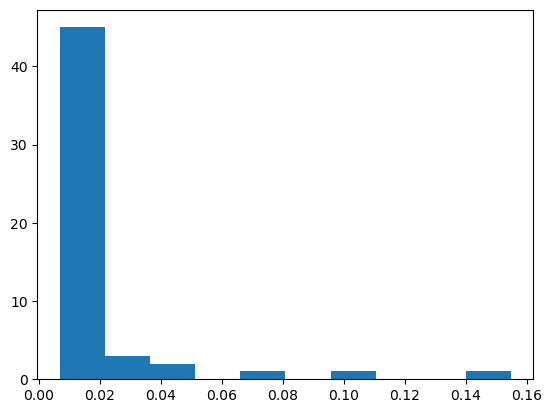

In [38]:
plt.hist(rf.feature_importances_)
plt.show()

In [39]:
common_lipids = np.array(common_lipids)

In [40]:
X_train.shape

(80000, 53)

In [41]:
rf.feature_importances_.argsort()[:-6:-1]


array([26, 51,  7, 43, 24])

In [42]:
print(pd.DataFrame(common_lipids[rf.feature_importances_.argsort()][:-6:-1]).to_latex())

\begin{tabular}{ll}
\toprule
{} &         0 \\
\midrule
0 &  LPE 22 4 \\
1 &  LPE 18 1 \\
2 &  LPE 20 2 \\
3 &  LPE 20 4 \\
4 &  LPE 20 1 \\
\bottomrule
\end{tabular}



## GNN approach (only if brain is treated as object)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [ ]:
coord = pd.read_csv("../data/75_regions_coord.txt", sep="\t")
# display(coord.head())
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(coord.x, coord.y, coord.z)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(18900, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
full_graph = [[[i, j] for i in range(50)] for j in range(50)]
full_graph = torch.tensor(np.concatenate(full_graph).T)

data_list = []
for human in ["H1", "H2", "H3", "H5"]:
    lipid_profiles = sz_lipids[sz_lipids.Brain_abbr == human].iloc[:, 2:-1].values.reshape(1,-1)
    lipid_profiles = torch.Tensor(lipid_profiles)
    print(lipid_profiles.shape)
    data = Data(
        x=lipid_profiles,
        edge_index=full_graph,
#         pos=coord[["x", "y", "z"]],
        y=1,
    )
    data_list.append(data)

for human in ["HA", "HB", "HC", "HD"]:
    lipid_profiles = h_lipids[h_lipids.Brain_abbr == human].iloc[:, 2:-1].values.reshape(1,-1)
    lipid_profiles = torch.Tensor(lipid_profiles)
    data = Data(
        x=lipid_profiles,
        edge_index=full_graph,
#         pos=coord[["x", "y", "z"]],
        y=0,
    )
    print(lipid_profiles.shape)
    data_list.append(data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
data_list

In [ ]:
loader = DataLoader(data_list, batch_size=1, shuffle=True)

In [ ]:
model(data_list[0])

In [ ]:
next(iter(loader))

In [ ]:
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    data = next(iter(loader)).to(device)    
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()